# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**: Rayna Hata, Ethan Holand

---

# Utils and Imports

Importing all necessary libraries.


In [8]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [9]:
# if os.path.exists('./content/data'):
#   shutil.rmtree('./content/data')

# # os.mkdir('./content')
# os.mkdir('./content/data')
# !wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O ./content/data/data.zip
# !unzip "./content/data/data.zip" -d "./content/"
# os.system("rm ./content/data/data.zip")
data_dir = './content/data/'


Utils Functions.

In [10]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

The dot product comes from the cosine of the angle between incident light and surface normal. 

Surface radiance: $L=\frac{\rho_d}{\pi}I\ \vec{n}\cdot\vec{l}=\frac{\rho_d}{\pi}I\ cos(\theta_i)$

Projected area appears when multiplying both sides by $dA$: $L dA = \frac{\rho_d}{\pi}I\ cos(\theta_i) dA$ where the projected area is $dA\ cos(\theta_i)$

Viewing direction doesn't matter because Lambertian model assumes that all surface is diffuse and all surfaces appear equally bright from all directions.

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

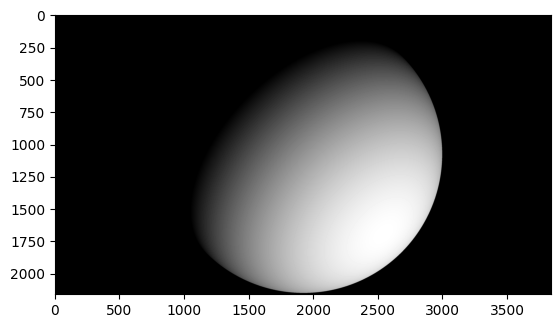

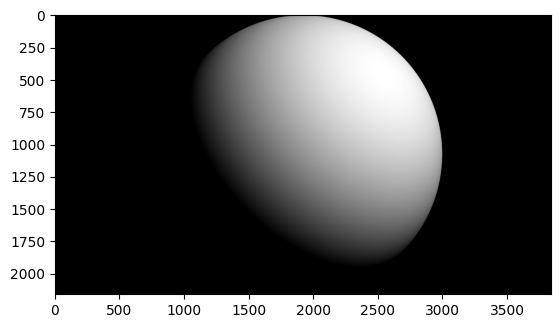

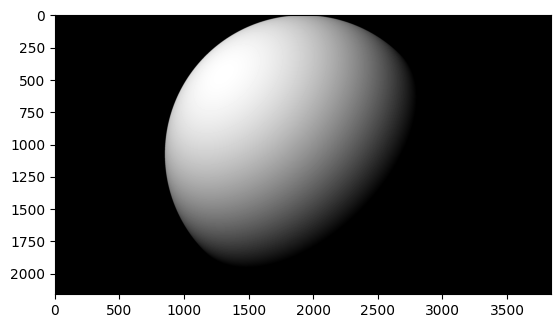

In [11]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None
    ### YOUR CODE HERE

    N = np.stack((X, Y, Z), axis = -1)
    image = np.maximum(0, np.sum(N*light, axis = -1))

    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [12]:
### YOUR CODE HERE

# perform SVD oon I
U, S, Vt = np.linalg.svd(I, full_matrices=False)
print(S)

### END YOUR CODE

[79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

I should have rank 3 because surface normal vectors should have 3 degrees of freedom. E.g. the set of all normal vectors in D space can be constrained by 3 images (assuming noiseless). The SVD yielded 7 values, which agrees since 7 > 3, but it shows that the results are overconstrained. We need to perform a least-square to minimize error.

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [13]:
from scipy import sparse
    
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    
    A = spkron(speye(I.shape[1]), sparse.csc_matrix(L.T))
    x = splsqr(A, I.T.flatten())[0]
    B = np.reshape(x, (I.shape[1], 3)).T
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

Construct A by stacking $L^T$ along the diagonal. the decision variable x will be all the $B$'s stacked up vertically, and the y vector will be a single-row stack of all 7 rows of $I$'s

---


### Q 1 (e) Albedos and normals (10 points)

---

abedo imagee has bright areas in ear, nose edge, and neck. It's likely that those are caused by shadows unaccounted by our model. 

normal image seems ot have les sof those issue, but coloring along the cneter seems to be a bit asymmetric, where we would assume the normals should transition from pointing left to right along a vertical axis.

---

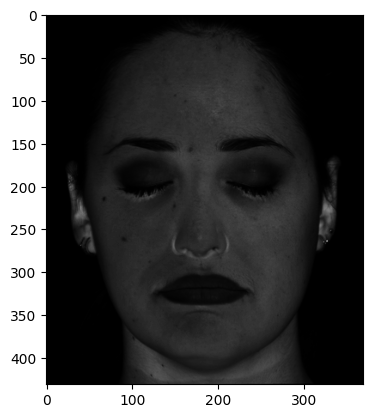

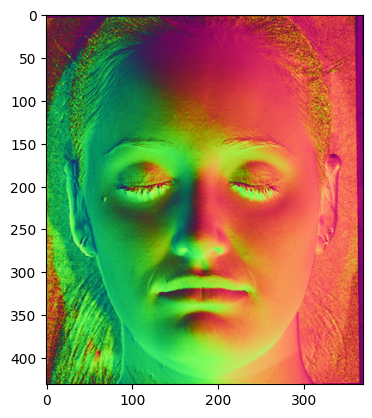

In [14]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE

    #  Albedos and normals. Estimate per-pixel albedos and normals from matrix B in  stimateAlbedosNormals. Note that the albedos are the magnitudes of the pseudonormals by definition. Calculate the albedos, reshape them into the original size of the images and display the resulting image using the utils function displayAlbedosNormals. Comment on any unusual or unnatural features you may find in the albedo image, and on why they might be happening. Make sure to display in the gray colormap.

    albedos = np.linalg.norm(B, axis = 0)
    normals = B/albedos
    

    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---
 
We know that $\{\forall\ (x,y) \in \mathbb{R}^2\ |\ \textbf{n} \perp \nabla z\ |\ z = f(x,y)\}$, which means $textbf{n}$ will be normal to the tangent plane at $x_0$ and $y_0$:

$n_1(x-x_0) + n_2(y-y_0) + n_3(f(x,y)-f(x_0,y_0)) = 0$ We can then take partials w.r.t. $x$ and $y$

$n_1 + n_3 \frac{\partial f}{\partial x} = 0 \rightarrow \frac{\partial f}{\partial x} = -\frac{n_1}{n_3}$

$n_2 + n_3 \frac{\partial f}{\partial y} = 0 \rightarrow \frac{\partial f}{\partial y} = -\frac{n_2}{n_3}$

---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

Given $ g= \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16 
\end{bmatrix}  $, we find $ g_x =  \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end{bmatrix}  $, and $ g_y = \begin{bmatrix}
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 
\end{bmatrix}  $

If we know $g(0,0) = 1$, first apply $g_x$: $ g = \begin{bmatrix} 1 & 2 & 3 & 4 \end{bmatrix}  $, then apply $g_y$: $ g= \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16 
\end{bmatrix}  $

We do it in the other order: $ g=  \begin{bmatrix} 1 \\ 5 \\ 9 \\ 13 \end{bmatrix} $, then $ g= \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16 
\end{bmatrix}  $

Both methods yield the same result.

To make them non integrable, adding sharp edges or noise to the gradients will work (creating discontinuities).

---

### Q 1 (h): Shape estimation (10 points)

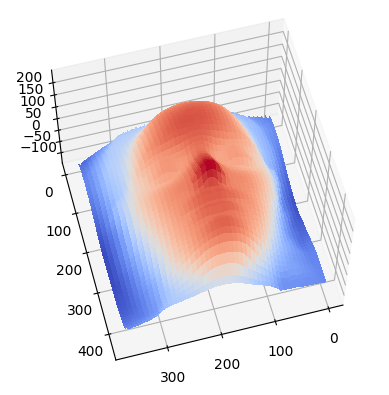

In [17]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE


#     Write a function estimateShape to apply the Frankot-Chellappa
# algorithm to your estimated normals. Once you have the function f(x, y), plot it as a surface in the
# function plotSurface. The result we expect of you is shown in Fig. 1.

    n1, n2, n3 = normals

    zx = -n1/n3
    zy = -n2/n3

    surface = integrateFrankot(zx.reshape(s), zy.reshape(s))
    
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

Given the SVD for $I = U\Sigma V^T$, and setting all values outside of the top 3 to zero.

To find the resulting factorization $\hat{I} = \hat{L}^T \hat{B}$, we set $\hat{L}^T$ to the first 3 columns of $U$, multiplying by the 3 sinular values in $\Sigma$, and then $\hat{B}$ will be the first 3 rows of $V^T$, leading to a rank 3 $\hat{I}$

---

### Q 2 (b): Calculation and visualization (10 points)

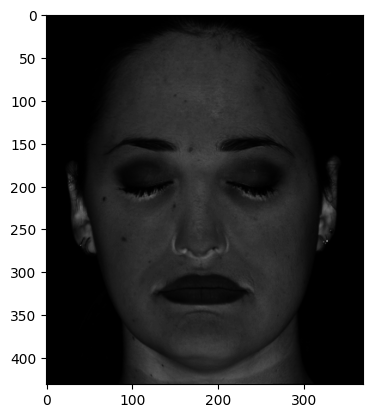

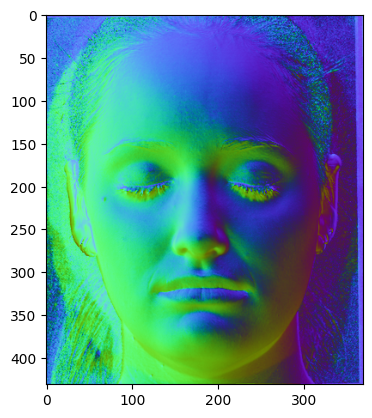

[[-0.1418  0.1215 -0.069   0.067  -0.1627  0.      0.1478]
 [-0.1804 -0.2026 -0.0345 -0.0402  0.122   0.1194  0.1209]
 [-0.9267 -0.9717 -0.838  -0.9772 -0.979  -0.9648 -0.9713]]
[[-26.66059692   3.43866505   5.70699349   1.44241464  -0.06003865
   -0.27946945   0.15146245]
 [-34.47622162  -8.40647171   3.08107583  -0.88467529  -0.63138948
   -0.04762871   0.05341986]
 [-21.45222072   1.81078981   1.30403367  -0.24462105   0.24906481
   -0.04829553  -0.82517057]
 [-33.36284755  -2.2711264   -0.0525438    0.06697537   1.12736793
    0.65736345   0.16823183]
 [-31.99401452   8.43764405  -0.94372086  -0.80765083  -0.62231735
    0.45869301   0.13876284]
 [-30.170518     1.69084744  -2.77169539  -0.64726697   0.49828372
   -0.93099653   0.17495455]
 [-29.8665421   -2.87597905  -5.7181112    1.35356057  -0.49251284
    0.05392747  -0.1174825 ]]


In [33]:
def estimatePseudonormalsUncalibrated(I):

  """
  Question 2 (b)

  Estimate pseudonormals without the help of light source directions.

  Parameters
  ----------
  I : numpy.ndarray
    The 7 x P matrix of loaded images

  Returns
  -------
  B : numpy.ndarray
    The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

  """
  B = None
  L = None
  ### YOUR CODE HERE

  U, S, Vt = np.linalg.svd(I, full_matrices=False) 
  B = Vt[:3,:]
  L = U @ np.diag(S)
  
  ### END YOUR CODE
  return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')

print(L)
print(LEst)


### Q 2 (c): Comparing to ground truth lighting

---

They're not similar. We can modify by changing order of multiplication: $\hat{I} = U(\Sigma V^T) = \hat{L}^T (\hat{B})$

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

it doesn't look like a face
---

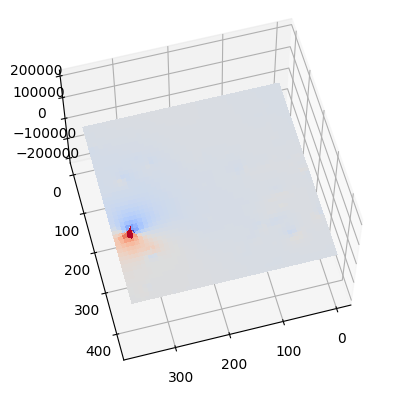

In [36]:
# Part 2 (d)
### YOUR CODE HERE

I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
surf_shape = estimateShape(normals, s)
plotSurface(surf_shape)
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

it looks like a face.

---


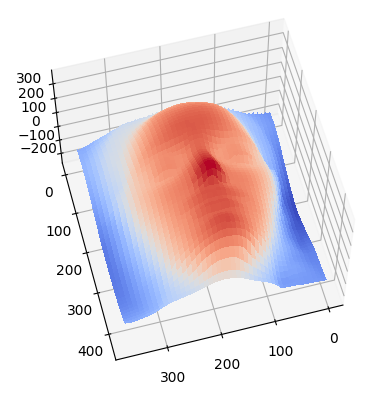

In [37]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE

I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
B = enforceIntegrability(B, s)
albedos, normals = estimateAlbedosNormals(np.diag([1,1,-1]) @ B)
surf_shape = estimateShape(normals, s)
plotSurface(surf_shape)

### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

$\mu$: stretch the gradient along the horizontal axis, gives effect of shifting one side of the face up (height direction)

$\nu$: stretch the gradient along the verical axis, gives effect of tilting the face up an downward

$\lambda$: no relative change along x and y, mainly the z axis grew, meaning the gradient magnitude increased.

---

<IPython.core.display.Javascript object>

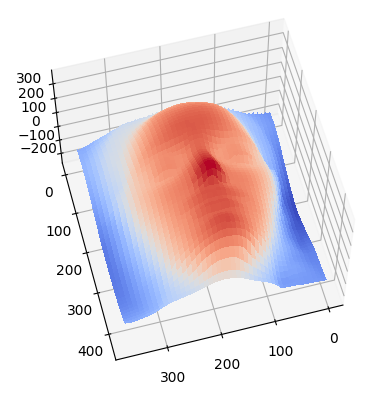

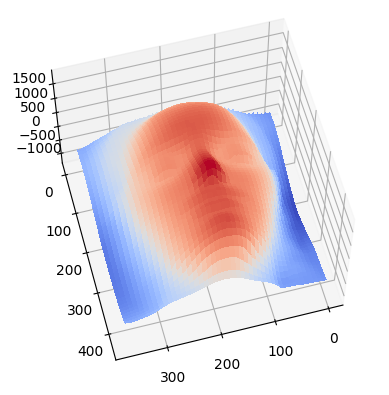

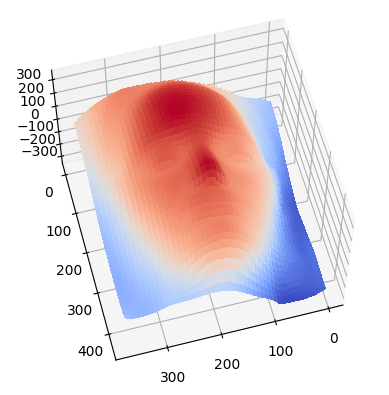

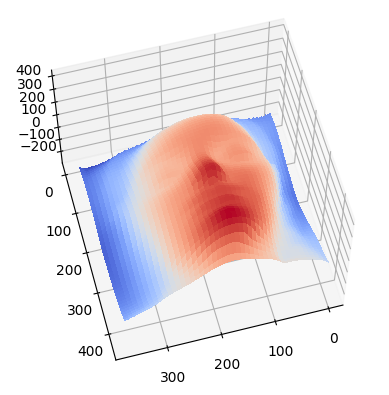

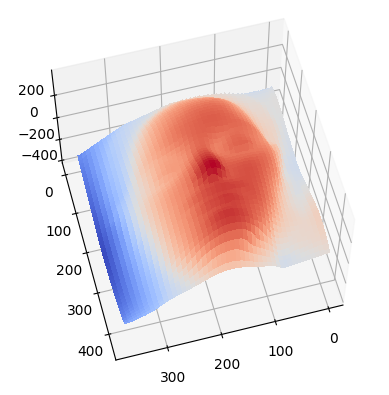

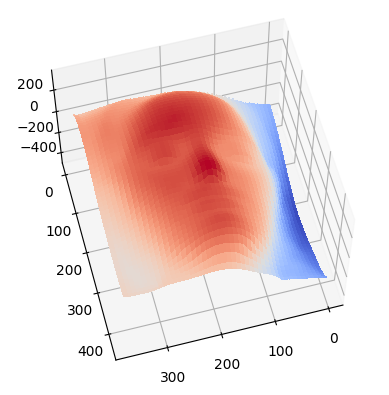

In [46]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE

plotBasRelief(normals, 0,0,1)
plotBasRelief(normals, 0,0,5)

plotBasRelief(normals, 0,5,1)
plotBasRelief(normals, 0,-5,1)

plotBasRelief(normals, 5,0,1)
plotBasRelief(normals, -5,0,1)

### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

minimize lambda, which decreases gradient magnitude

---

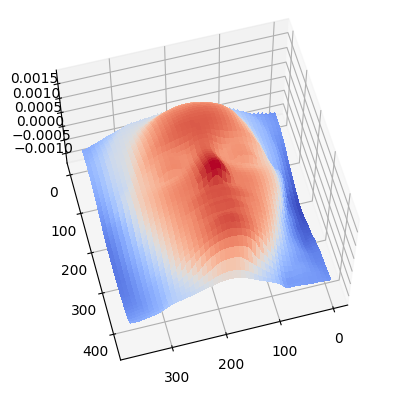

In [48]:
plotBasRelief(normals, 0,0,0.000005)

### Q 2 (h): More measurements

---

more data will give better least square solution. But it won't help resolve bas-relief ambiguity due to $\hat{I}$ still being rnak 3.

---